In [18]:
!ls

classifiers_mhcld.ipynb
codebook_descriptions.pickle
google_colab_t-sne_mental_health_client-level_data.ipynb
mhcld_puf_2021.csv
plots
t-sne_k-means_mhcld.ipynb
to_do.txt
unsupervised_learning.ipynb


In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [58]:
NUM_POINTS = 500_000
data = pd.read_csv("mhcld_puf_2021.csv")
data = data[:NUM_POINTS]

In [21]:
# Load data (deserialize)
import pickle
with open('codebook_descriptions.pickle', 'rb') as handle:
    codebook_descriptions = pickle.load(handle)

In [22]:
#disorder columns
#they are all 0/1 data
#these are dignoses for the disorders
#there are 13 of them
disorder_cols = ['TRAUSTREFLG','ANXIETYFLG','ADHDFLG','CONDUCTFLG','DELIRDEMFLG','BIPOLARFLG','DEPRESSFLG','ODDFLG','PDDFLG','SCHIZOFLG','PERSONFLG','ALCSUBFLG','OTHERDISFLG']

In [59]:
from sklearn.cluster import KMeans
#generate labels using k-means

In [60]:
#perform the elbow method
inertia = []
for k in range(3,20):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=0, n_init=10)
    kmeans.fit(data[disorder_cols])
    label_df = pd.DataFrame(kmeans.labels_,columns=['label'])
    inertia.append((k,kmeans.inertia_))

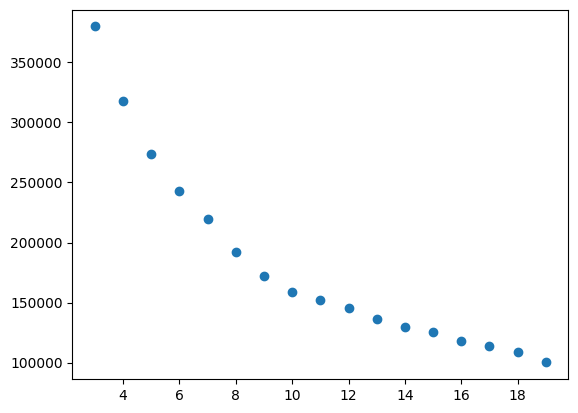

In [61]:
plt.scatter(np.array(inertia)[:,0],np.array(inertia)[:,1])
plt.show()

In [68]:
#somewhere between 7-9
NUM_CLUSTERS_ELBOW = 7
kmeans = KMeans(n_clusters=NUM_CLUSTERS_ELBOW, init='k-means++', max_iter=300, random_state=0, n_init=10)
kmeans.fit(data[disorder_cols])
label_df = pd.DataFrame(kmeans.labels_,columns=['label'])

In [24]:
from sklearn.manifold import TSNE

In [25]:
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=300)

In [26]:
tsne_results = tsne.fit_transform(data[disorder_cols])

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 500000 samples in 0.244s...
[t-SNE] Computed neighbors for 500000 samples in 1156.980s...
[t-SNE] Computed conditional probabilities for sample 1000 / 500000
[t-SNE] Computed conditional probabilities for sample 2000 / 500000
[t-SNE] Computed conditional probabilities for sample 3000 / 500000
[t-SNE] Computed conditional probabilities for sample 4000 / 500000
[t-SNE] Computed conditional probabilities for sample 5000 / 500000
[t-SNE] Computed conditional probabilities for sample 6000 / 500000
[t-SNE] Computed conditional probabilities for sample 7000 / 500000
[t-SNE] Computed conditional probabilities for sample 8000 / 500000
[t-SNE] Computed conditional probabilities for sample 9000 / 500000
[t-SNE] Computed conditional probabilities for sample 10000 / 500000
[t-SNE] Computed conditional probabilities for sample 11000 / 500000
[t-SNE] Computed conditional probabilities for sample 12000 / 500000
[t-SNE] Computed conditional pro

In [27]:
tsne_df = pd.DataFrame(columns=['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]

In [28]:
tsne_df.shape

(500000, 2)

In [69]:
tsne_results_labeled = label_df.merge(tsne_df, left_index=True, right_index=True)

(-50.0, 50.0)

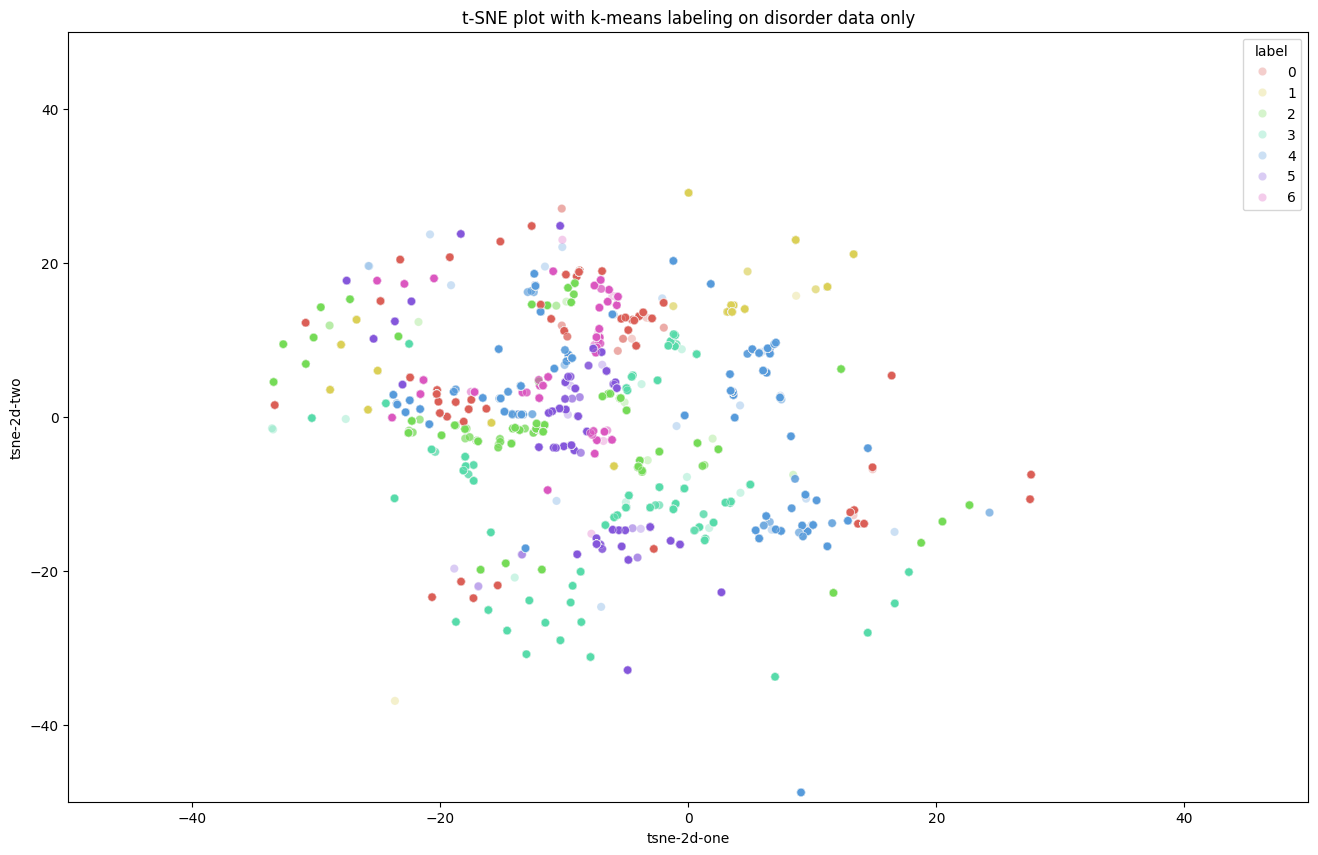

In [74]:
#plot the t-SNE results with diagnostic labels
plt.figure(figsize=(16,10))
plot = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", NUM_CLUSTERS_ELBOW),
    data=tsne_results_labeled,
    legend=True,
    alpha=0.3
)
plot.set(title='t-SNE plot with k-means labeling on disorder data only')
plt.xlim(-50,50)
plt.ylim(-50,50)

In [72]:
#apply elbow method by keeping list kmeans.inertia_ and plotting
#can also try silhouette coefficient, sklearn.metrics.silhouette_score

In [71]:
fig = plot.get_figure()
fig.savefig("./plots/tsne-plot_kmeans_elbow_method_disorder-data-only.png")